### 3.16.2 获取和读取数据集
比赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房子的特征，如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值“na”。只有训练数据集包括了每栋房子的价格，也就是标签。我们可以访问比赛网页，点击图3.8中的“Data”标签，并下载这些数据集。

我们将通过pandas库读入并处理数据。在导入本节需要的包前请确保已安装pandas库，否则请参考下面的代码注释。

In [1]:
# 如果没有安装pandas，则反注释下面一行
# !pip install pandas

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import initializers as init
print(tf.__version__)

2.18.0


假设解压后的数据位于./data/kaggle_house/目录，它包括两个csv文件。下面使用pandas读取这两个文件

In [2]:
train_data = pd.read_csv('../../data/kaggle_house/train.csv')
test_data = pd.read_csv('../../data/kaggle_house/test.csv')

训练数据集包括1460个样本、80个特征和1个标签。

In [3]:
train_data.shape # 输出 (1460, 81)

(1460, 81)

测试数据集包括1459个样本和80个特征。我们需要将测试数据集中每个样本的标签预测出来。

In [4]:
test_data.shape # 输出 (1459, 80)

(1459, 80)

让我们来查看前4个样本的前4个特征、后2个特征和标签（SalePrice）：

In [5]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


可以看到第一个特征是Id，它能帮助模型记住每个训练样本，但难以推广到测试样本，所以我们不使用它来训练。我们将所有的训练数据和测试数据的79个特征按样本连结。train_data.iloc[:, 1:-1]列出从第一列到最后一列所有的样本，concat将样本按列连接。

In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

### 3.16.3. 预处理数据
我们对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值为$μ$，标准差为$σ$。那么，我们可以将该特征的每个值先减去$μ$再除以$σ$得到标准化后的每个特征值。对于缺失的特征值，我们将其替换成该特征的均值。

数据标准化和缺失值处理：

1. **选择数值特征**：
- 找出数据集中所有非对象类型（即数值类型）的列
- `dtypes != 'object'` 排除了字符串等非数值类型的特征
- `.index` 获取这些数值特征的名称列表

2. **标准化处理**：
- 对每个数值特征进行标准化处理
- 使用 z-score 标准化方法：(x - 均值) / 标准差
- 这样处理后，每个特征的均值为0，标准差为1
- 这有助于让不同尺度的特征在模型训练中得到公平对待

3. **处理缺失值**：
- 将所有数值特征中的缺失值（NA）填充为0
- 因为数据已经标准化，用0填充相当于用该特征的均值填充

这种数据预处理的目的是：
- 使不同量级的特征可以被公平比较
- 帮助模型更好地学习和收敛
- 处理数据中的缺失值，使数据集完整可用

In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来将离散数值转成指示特征。举个例子，假设特征MSZoning里面有两个不同的离散值RL和RM，那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。如果一个样本原来在MSZoning里的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0。

使用pandas的`get_dummies`函数对数据集进行独热编码（One-Hot Encoding）处理。

1. **功能说明**：
   - 将分类特征（非数值特征）转换为数值形式
   - 每个分类值都会变成一个新的二进制特征列
   - `dummy_na=True` 表示将缺失值（NA）也作为一个独立的类别进行编码

2. **举例说明**：
   假设有一个"颜色"特征列：
   ```
   颜色: [红, 蓝, NA, 红]
   ```
   
   转换后会变成：
   ```
   颜色_红: [1, 0, 0, 1]
   颜色_蓝: [0, 1, 0, 0]
   颜色_NA: [0, 0, 1, 0]
   ```

3. **处理目的**：
   - 将分类数据转换为机器学习算法可以处理的数值形式
   - 保留缺失值信息，而不是简单地删除或填充
   - 避免引入分类变量之间的人为顺序关系

这种处理方式的优点：
- 许多特征（如房屋类型、街道类型等）是分类变量
- 缺失值本身可能包含有用信息（比如某些特征不适用于特定房屋）
- 独热编码可以让模型更好地理解分类特征的影响

In [8]:
all_features = pd.get_dummies(all_features, dummy_na=True)

可以看到这一步转换将特征数从79增加到了331。
最后，通过values属性得到NumPy格式的数据，并转成NDArray方便后面的训练

准备训练和测试数据，将数据转换为适合模型使用的格式。

1. **获取训练集大小**：
- 获取训练数据的样本数量
- `shape[0]` 返回数据框的行数

2. **准备训练特征**：
- 从所有特征中取出前n_train行作为训练特征
- 将数据转换为NumPy数组格式
- 指定数据类型为float（浮点数）

3. **准备测试特征**：
- 从所有特征中取出剩余行作为测试特征
- 同样转换为NumPy数组和浮点数类型

4. **准备训练标签**：
- 提取训练数据中的房价（SalePrice）作为标签
- reshape(-1, 1)将标签转换为列向量
- 同样转换为NumPy数组和浮点数类型


这段代码的目的是：
- 将数据从pandas格式转换为NumPy格式
- 确保所有数据都是浮点数类型
- 正确分离训练集和测试集
- 准备好可以直接输入到机器学习模型的数据格式

In [9]:
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values,dtype=float)
test_features = np.array(all_features[n_train:].values,dtype=float)
train_labels = np.array(train_data.SalePrice.values.reshape(-1, 1),dtype=float)

print(train_features.shape)
print(test_features.shape)

(1460, 330)
(1459, 330)


### 3.16.4. 训练模型
我们使用一个基本的线性回归模型和平方损失函数来训练模型,因为tensorflow中的keras中有对数均方根误差，故我们直接就使用。

In [10]:
# loss_f=keras.losses.mse
def get_net():
    net = keras.models.Sequential()
    net.add(keras.layers.Dense(1))
    return net

对数均方根误差的实现如下，因为已经keras中已经集成了对数均方根误差，故直接调用

In [11]:
log_rmse=keras.losses.MeanSquaredLogarithmicError

### 3.16.5. K 折交叉验证

我们在“模型选择、欠拟合和过拟合”一节中介绍了 K 折交叉验证。它将被用来选择模型设计并调节超参数。下面实现了一个函数，它返回第i折交叉验证时所需要的训练和验证数据。











这段代码实现了K折交叉验证中的数据划分功能。让我详细解释这个函数：

1. **函数参数说明**：
```python
def get_k_fold_data(k, i, X, y):
```
- k：总的折数（将数据分成多少份）
- i：当前使用第几折作为验证集
- X：特征数据
- y：标签数据

2. **基本验证和初始化**：
```python
assert k > 1
fold_size = X.shape[0] // k
X_train, y_train = None, None
```
- 确保k大于1（至少分成2折）
- 计算每一折的大小（整除）
- 初始化训练集变量

3. **数据划分过程**：
```python
for j in range(k):
    idx = slice(j * fold_size, (j + 1) * fold_size)
    X_part, y_part = X[idx, :], y[idx]
```
- 遍历k次，每次处理一折数据
- 使用切片获取当前折的数据

4. **数据分配逻辑**：
```python
    if j == i:  # 当前折作为验证集
        X_valid, y_valid = X_part, y_part
    elif X_train is None:  # 第一份训练数据
        X_train, y_train = X_part, y_part
    else:  # 将后续的训练数据拼接起来
        X_train = tf.concat([X_train, X_part], axis=0)
        y_train = tf.concat([y_train, y_part], axis=0)
```
- 如果是第i折，作为验证集
- 否则作为训练集的一部分
- 使用concat连接多个训练数据片段

这个函数的目的是：
- 实现K折交叉验证的数据划分
- 每次调用返回不同的训练集和验证集组合
- 确保所有数据都能轮流作为验证集
- 帮助评估模型的泛化性能

使用场景示例：
- 如果k=5，数据会被分成5份
- 每次调用时指定不同的i（0到4）
- 得到不同的训练集和验证集组合
- 最终可以进行5次训练和验证

In [12]:
def get_k_fold_data(k, i, X, y):
    """
    K折交叉验证数据集划分函数
    参数:
        k: 数据分成的折数
        i: 当前使用第i折作为验证集
        X: 特征数据
        y: 标签数据
    返回:
        训练集特征，训练集标签，验证集特征，验证集标签
    """
    # 确保k值大于1，否则无法进行交叉验证
    assert k > 1
    # 计算每一折的大小（样本数量）
    fold_size = X.shape[0] // k
    # 初始化训练集变量
    X_train, y_train = None, None
    
    # 遍历所有折
    for j in range(k):
        # 计算当前折的数据范围
        idx = slice(j * fold_size, (j + 1) * fold_size)
        # 获取当前折的特征和标签
        X_part, y_part = X[idx, :], y[idx]
        
        if j == i:  
            # 如果是第i折，作为验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:  
            # 如果是第一折（且不是验证集），直接作为训练集
            X_train, y_train = X_part, y_part
        else:  
            # 将当前折与已有的训练集连接
            X_train = tf.concat([X_train, X_part], axis=0)
            y_train = tf.concat([y_train, y_part], axis=0)
    
    return X_train, y_train, X_valid, y_valid

在 K 折交叉验证中我们训练 K 次并返回训练和验证的平均误差。

K折交叉验证训练过程：

1. **函数定义**：
```python
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
```
- 接收训练数据、折数和各种训练参数
- 包括学习率、权重衰减、批量大小等超参数

2. **交叉验证循环**：
```python
for i in range(k):
    data = get_k_fold_data(k, i, X_train, y_train)
    net = get_net()
```
- 进行k次训练
- 每次使用不同的数据划分
- 每次都创建一个新的神经网络

3. **模型编译**：
```python
net.compile(loss=keras.losses.mean_squared_logarithmic_error,
           optimizer=keras.optimizers.Adam(learning_rate))
```
- 使用均方对数误差作为损失函数
- 使用Adam优化器
- 设置指定的学习率

4. **模型训练**：
```python
history = net.fit(data[0], data[1],
                 validation_data=(data[2], data[3]),
                 epochs=num_epochs,
                 batch_size=batch_size,
                 validation_freq=1,
                 verbose=0)
```
- 使用训练数据训练模型
- 同时使用验证数据评估模型
- 记录训练过程中的损失变化

5. **结果输出和可视化**：
```python
print('fold %d, train rmse %f, valid rmse %f' % (i, loss[-1], val_loss[-1]))
plt.subplot(1, 2, 2)
plt.plot(loss, label='train')
plt.plot(val_loss, label='valid')
```
- 打印每一折的训练和验证误差
- 绘制损失曲线图
- 显示训练过程中损失的变化趋势

这个函数的主要目的是：
- 实现完整的K折交叉验证训练流程
- 评估模型的泛化性能
- 可视化训练过程
- 帮助调整和优化模型参数

通过这种方式，我们可以：
- 更好地评估模型性能
- 避免过拟合
- 获得更可靠的模型评估结果
- 直观地观察模型训练过程

In [13]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    """K折交叉验证训练函数

    Args:
        k: 折数
        X_train: 训练特征数据
        y_train: 训练标签数据 
        num_epochs: 训练轮数
        learning_rate: 学习率
        weight_decay: 权重衰减
        batch_size: 批量大小
    """

    # 创建一个图表用于显示所有折的结果
    plt.figure(figsize=(10, 6))

    # 使用颜色映射来处理任意数量的折
    import matplotlib.cm as cm
    colors = cm.rainbow(np.linspace(0, 1, k))

    for i in range(k):
      data = get_k_fold_data(k, i, X_train, y_train)
      net = get_net()

      net.compile(
          loss=keras.losses.MeanSquaredLogarithmicError(),
          optimizer=keras.optimizers.Adam(learning_rate)
      )

      history = net.fit(
          data[0],
          data[1],
          validation_data=(data[2], data[3]),
          epochs=num_epochs,
          batch_size=batch_size,
          validation_freq=1,
          verbose=0
      )

      loss = history.history['loss']
      val_loss = history.history['val_loss']

      print('fold %d, train rmse %f, valid rmse %f' % (i, loss[-1], val_loss[-1]))

      # 使用颜色映射中的颜色
      plt.plot(loss,
               color=colors[i],
               linestyle='-', 
               label=f'train_fold_{i}')
      plt.plot(val_loss,
               color=colors[i],
               linestyle='--',
               label=f'valid_fold_{i}')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for All Folds')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

### 3.16.6. 模型选择
我们使用一组未经调优的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测试误差

fold 0, train rmse 29.185255, valid rmse 29.329741
fold 1, train rmse 26.157846, valid rmse 26.234379
fold 2, train rmse 27.096159, valid rmse 27.250902
fold 3, train rmse 27.167912, valid rmse 26.748205
fold 4, train rmse 26.173740, valid rmse 26.263100


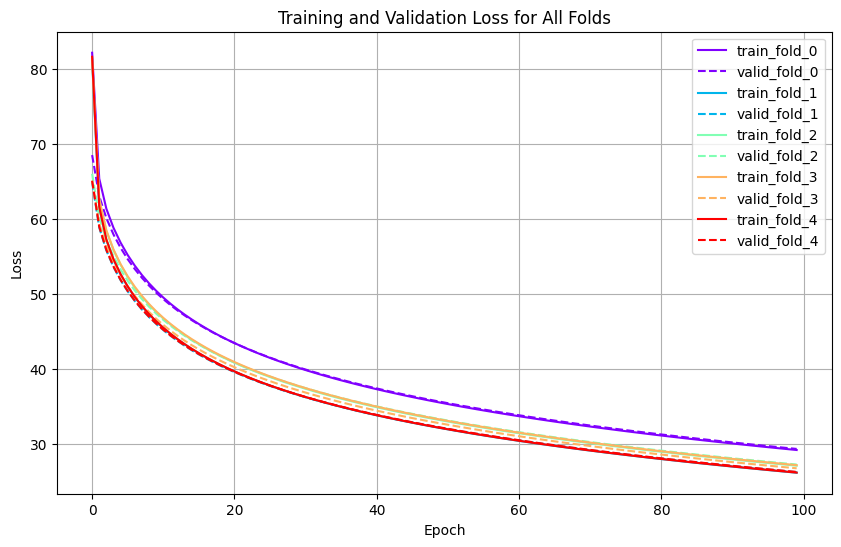

In [14]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.1, 0, 64
k_fold(k, train_features, 
       train_labels, num_epochs, lr,
       weight_decay, batch_size)

### 3.16.7. 预测并在Kaggle提交结果
下面定义预测函数。在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式。

1. **数据准备**：
```python
x_train = tf.convert_to_tensor(train_features, dtype=tf.float32)
y_train = tf.convert_to_tensor(train_labels, dtype=tf.float32)
x_test = tf.convert_to_tensor(test_features, dtype=tf.float32)
```
- 将训练特征、训练标签和测试特征转换为TensorFlow张量
- 指定数据类型为float32，确保数值计算的准确性

2. **模型构建**：
```python
model = keras.models.Sequential([
    keras.layers.Dense(1)
])
```
- 创建一个简单的线性回归模型
- 只包含一个全连接层，输出维度为1（预测房价）

3. **模型配置**：
```python
model.compile(
    optimizer=keras.optimizers.Adam(0.5),
    loss=keras.losses.MeanSquaredLogarithmicError()
)
```
- 使用Adam优化器，学习率设为0.5
- 使用均方对数误差作为损失函数（适合房价预测这类正值预测问题）

4. **模型训练**：
```python
model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0)
```
- 训练200个周期
- 每批次使用32个样本
- verbose=0表示不打印训练过程

5. **预测和结果处理**：
```python
preds = np.array(model.predict(x_test))
test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
```
- 使用训练好的模型对测试数据进行预测
- 将预测结果重塑并添加到测试数据框中

6. **生成提交文件**：
```python
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv('submission.csv', index=False)
```
- 将预测的房价与房屋ID合并
- 保存为CSV文件，用于竞赛提交

这个代码展示了一个完整的机器学习项目流程：
- 数据准备
- 模型构建
- 模型训练
- 预测
- 结果导出


In [15]:
x_train=tf.convert_to_tensor(train_features,dtype=tf.float32)
y_train=tf.convert_to_tensor(train_labels,dtype=tf.float32)
x_test=tf.convert_to_tensor(test_features,dtype=tf.float32)
model=keras.models.Sequential([
  keras.layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(0.5),
    loss=keras.losses.MeanSquaredLogarithmicError()
)
model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0)
preds=np.array(model.predict(x_test))
test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv('submission.csv', index=False)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
